# 2DConvolution in OpenCL
We can convert the C++ description of 2D convolution into OpenCL in a realtive straightforward manner. This requires splitting the code into two files -- a host file, and a kernel file. While this separation may seem forced, it naturally fits the **offload** model where the compute intensive portions of your application are moved to the accelerator. In our case, the nested for loops must be moved to the accelerator.

Writing kernel code in OpenCL requires a different way of thinking about computation. The kernel file for 2D convolution captures the operations that must be performed at a single pixel. This idea is important -- by only specifying the per-pixel computation in the kernel, we are relying on the OpenCL compiler and runtime to transform our code automatically to parallelize most effectively on the accelerator. This is also the reason behind OpenCL's platform portability claim. We're using PyOpenCL, which provides a convenient front-end to the execution of the code on CPUs, GPUs and FPGAs.

In [1]:
# Modeled on github.com/BLVC/caffe.git

# magic function to import numpy, matplotlib, etc in jupyter notebook
from pylab import * 
from scipy import ndimage, misc, signal;
import numpy as np
import matplotlib.pyplot as plt

# display plots in this notebook
%matplotlib inline
# set display defaults
plt.rcParams['figure.figsize'] = (5, 5)        # medium images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

#load the ipython extensions for pyopencl
%load_ext pyopencl.ipython_ext

The host code in OpenCL often must be written to target a given platform. It looks ugly in C/C++ but its mostly structurally same across all applications. Hence, we're using PyOpenCL -- its simple, convenient, pretty and multi-platform.

First, we must include the correct PyOpenCL headers

In [2]:
from __future__ import absolute_import, print_function
import numpy as np
import pyopencl as cl

Next, we must setup the OpenCL platform. Again, the C++ implementation of this is not only ugly, its tedious, annoying, and error-prone. The Python-based structure is pretty broilerplate and with few modifications, you can use it for other applications. There is also extensive error checking done in the PyOpenCL libary on your behalf.

In [3]:
ctx = cl.create_some_context(interactive=True)
queue = cl.CommandQueue(ctx)

Choose platform:
[0] <pyopencl.Platform 'Apple' at 0x7fff0000>
Choice [0]:0
Choose device(s):
[0] <pyopencl.Device 'Intel(R) Core(TM) i5-6600 CPU @ 3.30GHz' on 'Apple' at 0xffffffff>
[1] <pyopencl.Device 'AMD Radeon R9 M395 Compute Engine' on 'Apple' at 0x1021c00>
Choice, comma-separated [0]:0
Set the environment variable PYOPENCL_CTX='0:0' to avoid being asked again.


In [4]:
%%cl_kernel 
__kernel void convolve2D(
    __global float *in,     // W*H input images
    __constant float *filt, // K*K filter kernel
    __global float *out)    // W*H output images
{
    // get pixel position
    int W = get_global_size(0);
    int H = get_global_size(1);
    int K = 3;
    
    // get image resolution
    int x = get_global_id(0); 
    int y = get_global_id(1);

    float sum = 0;
    int r = 0, c = 0;

    // loop over kernel rows
    for (r = 0; r < K; r++) {
        // loop over kernel columns
        for(c = 0; c < K; c++) {
            sum += filt[r*K+c]*in[((y+r)*W+x)+c];
        }
    }
    out[y*W+x] = sum;
}

/usr/local/lib/python3.5/site-packages/pyopencl-2016.2-py3.5-macosx-10.11-x86_64.egg/pyopencl/cffi_cl.py:1456: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


In the **convolve2D** OpenCL kernel code shown above, we observe a few new portions. 
1. The **get_global_size** method is used to decide the image resolution $W$x$H$. 
2. The **get_global_id** is crucial to identify the $x$,$y$ position of the current pixel being processed. The concept of global ids is important. The OpenCL runtime will take this kernel and parallelize it across the global workgroup. Each workitem in the workgroup will have a unique global id. For this application, it represents the pixel position $x$,$y$. 
3. The nested for loops over the rows and columns of the image are gone! Only the loops over the kernels are left. This is tied to the idea of global workgroup size. When we set the global workgroup size to $W$x$H$, the OpenCL compiler automatically implicitly introduces the nested for loops over the image rows and columns for you. Additionally, the OpenCL runtime also parallelizes each pixel operation across the OpenCL device for you automatically. 

Next, we compile the kernel into an OpenCL executable. This is done for you behind-the-scenes in Jupyter. But in PyOpenCL, you would run ```prg=cl.Program(ctx,code).build()```

Now that the OpenCL objects have been created, kernels compiled, devices detected and targeted, we can proceed to the real meat of the code. Here, we allocate **host** and **device** memory structures. This step is important to understand. The offload model uses the accelerator to speedup portions of the code that are bottleneck in your application. When you offload, you need to copy over the data that the accelerator needs to access. This is an artifcact of the separation of memory spaces of the accelerator and host. In future OpenCL releases, this might go away as memory spaces can be unified. Some recent NVIDIA GPUs unify the spaces already. 

The device memories are allocated using **cl.Buffer** which is similar to **malloc** on the host. There are fancy tags that provide more information to the OpenCL compiler to optimize storage of the device arrays. 

We then come to the key OpenCL function **clEnqueueNDRangeKernel** which is implicitly run as **prg.convolve2d**. This is used to run your kernel in parallel on the accelerator. 

There are two arguments to the call after *queue* which are the **global** and **local** workgroup sizes. These numbers are used by the compiler/runtime to auto-parallelize the kernel code across all work items. For our case the **global** workgroup size is $W$x$H$ (or **in_np.shape**) to reflect the resolution of the image. We process each pixel independently in each OpenCL workitem. The **local** workgroup size is an optional hint that suggests how many workitems to pack into an OpenCL **Compute Unit**. For this example, this doesn't really matter so much, but this can be used to optimize performance when data sharing is concerned.

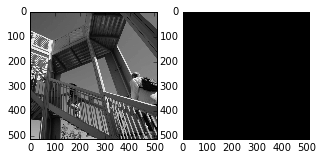

In [5]:
from scipy import ndimage, misc, signal;

f = misc.ascent();
in_np = f;

filt_np = np.array([[1,2,1],[2,4,2],[1,2,1]]);

mf = cl.mem_flags
in_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=in_np)
filt_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=filt_np)
out_g = cl.Buffer(ctx, mf.WRITE_ONLY, in_np.nbytes)

# Run OpenCL convolve2D function
print(in_np.shape);
convolve2D(queue, in_np.shape, None, in_g, filt_g, out_g)

out_np = np.empty_like(in_np)
cl.enqueue_copy(queue, out_np, out_g)

fig, (a, b) = plt.subplots(1, 2)
a.imshow(in_np, cmap='gray')
b.imshow(out_np, cmap='gray')
plt.show() # apparently, plt.show() works than fig.show() in juypter

This shows the same flow working through OpenCL.